[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1zo8ocqqa9AndeoPtxOWow6Ri1sqn4DmL)

# **STORE SALES - TIME SERIES FORECASTING**
Este es un problema de Machine Learning donde se intentan predecir las ventas de ciertas tiendas de la corporación favorita en Ecuador para un periodo de tiempo específico. <br>
Los datos del proyecto se obtienen deste la  competición de Kaggle  [Sales Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data). En cuadernos pasados [Data Exploration](https://colab.research.google.com/drive/17Rqvx5LU_KTMkuc75PXgepm7oRePLaYR#scrollTo=xJJSDuil8m2r) y [Análisis](https://colab.research.google.com/drive/1QbxLJz7dDIL4BOG1yaVlum-fndTScgQe) se realizó una exploración de los datos. 

En el Notebook [03- Modelo SVR](https://colab.research.google.com/drive/1-Jy0yyw7-SmOxK4YWuwvFd-jXT6bzMR6#scrollTo=LE7Jd1-v19VJ) se evaluó el desempeño del módelo SVR a nuestro proyecto. En este Notebook se usará la combianción de un módelo no supervisado **PCA** y un módelo supervisado **Support Vector Regressor** para la predicción de ventas, se encontrarán los mejores hiperparametros y se graficarán las curvas de aprendizaje

# Librerías a Usar

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve 

from google.colab import files 
import warnings
warnings.filterwarnings('ignore')

# Adquisición de Datos desde Kaggle
Usted puede ejecutar este Notebook sin necesidad de desacrgar los archivos y subirlios. Para eso sóo deberá subir su credencial de Kaggle, para eso:
1. en tu cuenta de kaggle ve a settings -> Create Token
2. Se descargará un archivo ```.json ``` con tus credenciales
3. Ese archivo es el que debes subir cuando al ejecutar el siguiente comando. 

In [ ]:
print('Por favor inserte sus credencial se Kaggle, en archivo .json')
files.upload()

Por favor inserte sus credencial se Kaggle, en archivo .json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felipevasquezu","key":"eb7b2c1020732009b3b57f08a0eacbb3"}'}

## Descargar los Dataset directamente desde Kaggle

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c store-sales-time-series-forecasting
! unzip store-sales-time-series-forecasting.zip
! rm store-sales-time-series-forecasting.zip
! rm kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 84% 18.0M/21.4M [00:00<00:00, 83.4MB/s]
100% 21.4M/21.4M [00:00<00:00, 84.8MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [ ]:
path=''
# Load train
train_df = pd.read_csv(path+'train.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
# Load Test
test_df = pd.read_csv(path+'test.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
#Load stores
store_df = pd.read_csv(path+'stores.csv')
#Load oil 
oil_df = pd.read_csv(path+'oil.csv',parse_dates=['date'], infer_datetime_format=True)
#Load holidays
holiday_df= pd.read_csv(path+'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
#Load transactions
transaction_df = pd.read_csv(path+'transactions.csv', parse_dates=['date'], infer_datetime_format=True)

# **Dataset de Trabajo**
En esta sección se hrá un procesamiento de datos. Ver notebook [01 Model Random Forest](https://colab.research.google.com/drive/11pjEF8BYzTofnjmkf3kUST56tRwlW1V6#scrollTo=dFea7npvaz-b) para más detalles.  <br>
Originalmente se poseen las ventas por familia de artículo (52 familias distintas ), por tienda (54 tiendas distintas), por día (desde el ``` 2013-01-01 ``` hasta el ``` 2017-08-15 ```) con un total de $3'000.888$ de filas. Para alcances de este proyecto se analizarán solo la suma de las  ventas por tienda, por día, en las mismas fechas, recogiendo un total de $90.204$ filas. <br>

Las columnas del Dataset construido contiene columnas como: precio del petroleo en ese día ```oil_price``` total de artículos en promoción: ```onpromotion```, total de transacciones de la tienda ```transactions```, determina si el Feriado es a nivel nacional, de estado o de ciudad. <br>

Dada la gran relación que tienen las ventas según las fechas, se han creados otras caracteriticas relacionadas como: día de la semana, año, si es fin de semana, semana del año, mes, si es inicio o fin de mes, si es inicio o fin de año, si es fecha de pago. <br> 

Por último para aplicar las series de tiempo se generan lags para las ventas, transacciones y precio del petroleo. La función diseñada a continuación permite ingresar el número de lags para las 3 instancias anteriores. Según la exploración que se hizo en notebooks anteriores se define 
$lag_{sales}=7 $,     $\;lag_{onpromotion}=3$,   $\; lag_{oil}=3$ 

Formando en total un Dataset de trabajo de $90.204$ filas y $33$ columnas. 

## Funciones para generar Dataset

In [ ]:
def create_lags_by_column(df,num_lags,column):
  new_df =  pd.DataFrame(columns=df.columns)
  for y in range(1,55):
    current_df = df[df['store_nbr']== y ]
    for i in range(1,num_lags+1 ):
      current_df[f'lag_{column}_{i}'] = current_df[column].shift(i)

    current_df.dropna(inplace=True)
    current_df.reset_index(inplace=True)
    new_df = pd.concat([new_df, current_df], axis=0, ignore_index=True)
  return new_df

In [ ]:
def create_date_features(main_df):
  def get_date_features(df):
    df.loc[:,'day'] = df.date.dt.day
    df.loc[:,'month'] = df.date.dt.month.astype("int8")
    df.loc[:,'day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df.loc[:,'year'] = df.date.dt.year.astype("int32")
    df.loc[:,"is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df.loc[:,'week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df.loc[:,'is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df.loc[:,'is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df.loc[:,'is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df.loc[:,'is_year_end'] = df.date.dt.is_year_end.astype("int8")
    return df
  pd.options.mode.chained_assignment = None
  main_df = get_date_features(main_df)
  main_df.loc[:,"wageday"] = pd.Series(np.where((main_df['is_month_end'] == 1) | (main_df["day"] == 15), 1, 0)).astype("int8")
  return main_df

In [ ]:
def create_main_df2(df,oil,transaction,holiday,num_sales_lags,num_oil_lags,num_trans_lags):
  def create_holidays(df,holidays):
    #Creando Holidays 

    holiday = holidays[holidays['transferred'] == False].copy()
    holiday.rename(columns = {'type':'holiday_type'},inplace=True)
    holiday.drop(['transferred', 'description'], axis=1, inplace=True)

    #Festivos nacionales ( aplica a todas las tiendas)
    national_holidays = holiday[holiday['locale'] == 'National'][['date','holiday_type']].copy()
    national_holidays.rename(columns = {'holiday_type':'national_holiday_type'},inplace=True)
    national_holidays
    national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)

    #Festivos de estados 
    state_holidays = holiday[holiday['locale'] == 'Regional'][['date','locale_name','holiday_type']].copy()
    state_holidays.rename(columns = {'locale_name':'state','holiday_type':'state_holiday_type'},inplace=True)
    state_holidays

    #Festivos por ciudad 
    city_holidays = holiday[holiday['locale'] == 'Local'][['date','locale_name','holiday_type']].copy()
    city_holidays.rename(columns = {'locale_name':'city','holiday_type':'city_holiday_type'},inplace=True)

    #Merge
    df = pd.merge(df, national_holidays, how='left', on=['date']) 
    df = pd.merge(df, state_holidays, how='left', on=['date','state']) 
    df = pd.merge(df, city_holidays, how='left', on=['date','city']) 

    #Convirtiendo columnas holidays a binarias 
    df.loc[df['national_holiday_type'].notna(), 'national_holiday_type'] = 1
    df.loc[df['national_holiday_type'].isna(), 'national_holiday_type'] = 0
    df['national_holiday_type'] =df['national_holiday_type'].astype(int)

    df.loc[df['state_holiday_type'].notna(), 'state_holiday_type'] = 1
    df.loc[df['state_holiday_type'].isna(), 'state_holiday_type'] = 0
    df['state_holiday_type'] =df['national_holiday_type'].astype(int)


    df.loc[df['city_holiday_type'].notna(), 'city_holiday_type'] = 1
    df.loc[df['city_holiday_type'].isna(), 'city_holiday_type'] = 0
    df['city_holiday_type'] =df['national_holiday_type'].astype(int)

    #Eliminado duplicados
    dup = df[['date','store_nbr']].duplicated()
    df.drop(index=df[dup].index,inplace=True)

    return df
  
  def create_oil(df,oil):
    oil_data = oil.copy()
    oil_data['dcoilwtico'] = oil_data['dcoilwtico'].fillna(oil_data['dcoilwtico'].rolling(3, min_periods=1).mean())
    oil_data = oil_data.rename(columns={'dcoilwtico': 'oil_price'})
    oil_data.loc[0,'oil_price']=oil_data.loc[1,'oil_price'] #setting first oil price
    df= pd.merge(df,oil_data,on='date',how='left')
    df['oil_price'].fillna(df['oil_price'].rolling(3, min_periods=1).mean(),inplace=True)
    return df

  df_main = df.copy()
  df_main.drop(['family'],axis=1,inplace=True)
  df_main = df_main.groupby(['date','store_nbr']).sum()[['sales','onpromotion']].reset_index()

  #Date features 
  create_date_features(df_main)

  #Transactions
  df_tran = transaction_df.groupby(['date','store_nbr']).sum().reset_index()
  df_main =  pd.merge(df_main,df_tran, on=['date','store_nbr'],how='left')
  df_main['transactions'].fillna(0,inplace=True)

  #Stores
  df_main = pd.merge(df_main,store_df, on='store_nbr',how='left')
  
  #Holidays
  df_main = create_holidays(df_main,holiday)

  #sorting DF 
  df_main = df_main.sort_values(['store_nbr','date'])

  #Merge Oil
  df_main = create_oil(df_main,oil)


  #Corregir los datos de la tienda 52
  sales_8=df_main[(df_main['store_nbr']==8) &(df_main['date']<'2017-04-20')].sales.values
  onpromo_50=df_main[(df_main['store_nbr']==50) & (df_main['date']<'2017-04-20')].onpromotion.values
  trans_34=df_main[(df_main['store_nbr']==34) & (df_main['date']<'2017-04-20')].transactions.values

  df_main['sales'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=sales_8
  df_main['onpromotion'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=onpromo_50
  df_main['transactions'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=trans_34


  #Creating Lags 
  if num_sales_lags>0 :
    df_main = create_lags_by_column(df_main,num_sales_lags,'sales')
    df_main = df_main.drop(columns=['index'])
  
  if num_oil_lags>0 :
    df_main = create_lags_by_column(df_main,num_oil_lags,'oil_price')
    df_main = df_main.drop(columns=['index'])
    
  if num_trans_lags>0 :
    df_main = create_lags_by_column(df_main,num_trans_lags,'transactions')
    df_main = df_main.drop(columns=['index'])

  #Deleting unecesary columns
  df_main = df_main.drop(columns=['city','state','cluster','type'])

  return df_main

## Generar Dataset
Basados en la función anterior se genera el Dataset de trabajo 

In [ ]:
# los parametros en orden son: df,oil,transaction,holiday,num_sales_lags,num_oil_lags,num_trans_lags

main_dataset=create_main_df2(train_df,oil_df,transaction_df,holiday_df,7,3,3) #Dataset General
main_df_train=main_dataset[main_dataset["date"]<="2017-03-01"]                #Dataset para el train
main_df_test=main_dataset[main_dataset["date"]>"2017-03-01"]                  #Dataset para el test

# **Módelo PCA + SVR**
Se evaluará el desempeño de la combinación de un módelo no supervisado: PCA (Principal Component Analysis) y un módelo supervisado: SVR (Support Vector Regressor)

## Preparar Datos, Módelo PCA y Módelo SVR
Se iniciará el análisis del Módelo PCA+SVR para una sola tienda. Luego se extnderá el análisis de predicciones y curvas de aprendizajes para todas las tiendas, demostrando similutud entre las tiendas.

In [ ]:
t=np.random.randint(low=1, high=55)
print('Tienda elegida: ', t)

main_df_train_filtered = main_df_train[main_df_train['store_nbr']==t]
main_df_test_filtered = main_df_test[main_df_test['store_nbr']==t]

columns_serie = main_df_train_filtered.columns.values
columns_serie = np.delete(columns_serie,[0,2]) #Deleted date and sales 

Xtrain = main_df_train_filtered.loc[:,columns_serie].values
Ytrain = main_df_train_filtered.loc[:,'sales'].values
Xtest = main_df_test_filtered.loc[:,columns_serie].values
Ytest = main_df_test_filtered.loc[:,'sales'].values

# Para usar el módelo SVR se deben scalar los datos 
sc_x = StandardScaler()
sc_y = StandardScaler()
X_tr = sc_x.fit_transform(Xtrain)
y_tr = sc_y.fit_transform(Ytrain.reshape(-1,1)) 
X_ts = sc_x.fit_transform(Xtest)
y_ts = sc_y.fit_transform(Ytest.reshape(-1,1)) 

Tienda elegida:  41


In [ ]:
# Crear y entrenar modelo PCA
pca = PCA()
pca.fit(X_tr)

PCA()

In [ ]:
#Determinar el numero óptimo de componentes 
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumsum_variance >= 0.95) + 1
print('Transformar a: ',n_components)

Transformar a:  15


In [ ]:
#Entrenar el modelo con el número de componentes
pca = PCA(n_components=n_components)
pca.fit(X_tr)
X_tr_pca  = pca.transform(X_tr)[:, :n_components]
X_ts_pca  = pca.transform(X_ts)[:, :n_components]

In [ ]:
regressor=SVR()
regressor.fit(X_tr_pca, y_tr)  #ajuste de los datos de entrenamiento 


SVR()

In [ ]:
#Parámetros por defecto que tare el SVR
regressor.get_params() 


{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Métrica de desempeño: Root Mean Squared Logaritmic Error

$$ \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $$

In [ ]:
#Prediccion y error
#Xts_pca_svr=sc_x.fit_transform(X_ts_pca)
y_hat = regressor.predict(X_ts_pca)
y_pred = sc_y.inverse_transform(y_hat.reshape(-1,1))
rmsle_test =(mean_squared_log_error(Ytest, y_pred ,squared=False))
print("RMSLE Test Support Vector Regressor : %.3f"%rmsle_test)

RMSLE Test Support Vector Regressor : 0.135


## Encontrar los mejores parámetros del módelo
Se partirá de un ``` kernel``` de tipo radial ```'rbf' ```. 
```C``` se refiere al parámetro de regularizacio,.  ```gamma``` es el coeficiente del kernel y ```epsilon``` es el margen de error. <br>
Debido al elevado costo cumputacional que conlleva encontrar parametros para las 52 tiendas, se encontrarán los mejores parametros para los datos de una tienda  especifica y se asumirá que todas las tiendas siguien un comportamiento similar. Como se verá luego, se obtienen buenos resultados con esta aproximación. 


Método de Iteración manual: <br> 
Se construye una malla con todas las posibles combinaciones de los parametros a evaluar, se itera para cada caso y se halla el RSMLE

In [ ]:
param_grid = {'C': [1, 10, 50, 100], 'gamma': [0.1, 0.01, 0.001, 1e-4], 'epsilon':[0.001, 0.01, 0.1]}
grid=list(product(param_grid['C'], param_grid['gamma'], param_grid['epsilon']))

In [ ]:
columns_serie = main_df_train_filtered.columns.values
columns_serie = np.delete(columns_serie,[0,2]) #Deleted date and sales 

Xtrain = main_df_train.loc[:,columns_serie].values
Ytrain = main_df_train.loc[:,'sales'].values
Xtest = main_df_test.loc[:,columns_serie].values
Ytest = main_df_test.loc[:,'sales'].values

# Para usar el módelo SVR se deben scalar los datos 
sc_x = StandardScaler()
sc_y = StandardScaler()
X_tr = sc_x.fit_transform(Xtrain)
y_tr = sc_y.fit_transform(Ytrain.reshape(-1,1)) 
X_ts = sc_x.fit_transform(Xtrain)
y_ts = sc_y.fit_transform(Ytest.reshape(-1,1))

pca = PCA()
pca.fit(X_tr)
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumsum_variance >= 0.95) + 1
pca = PCA(n_components=n_components)
pca.fit(X_tr)
X_tr_pca  = pca.transform(X_tr)[:, :n_components]
X_ts_pca  = pca.transform(X_ts)[:, :n_components]

In [ ]:
#Iterar fit y puntaje para cada posible combinación de parametros 
puntuacion=np.zeros(len(grid))
for i in range(len(grid)):
    param=grid[i]
    regressor = SVR(C=param[0],gamma=param[1],epsilon=param[2])
    regressor.fit(X_tr_pca, y_tr)
    #Xts_pca_svr=sc_x.fit_transform(X_ts_pca)
    y_hat = regressor.predict(X_ts_pca)
    y_pred = sc_y.inverse_transform(y_hat.reshape(-1,1))
    puntuacion[i]=(mean_squared_log_error(Ytest, y_pred ,squared=False))
  

In [ ]:
#Formar un DataFrame con los puntajes obtenidos en las iteraciones
tun_params_SVR=pd.DataFrame(grid, columns=['C','gamma','epsilon'])
tun_params_SVR['RMSLE']=puntuacion
tun_params_SVR=tun_params_SVR.sort_values(by='RMSLE')
display(tun_params_SVR.head(5))

print('\n Los mejores parámetros encontrados son:')
best_params=tun_params_SVR.loc[np.argmin(puntuacion)]
best_params

In [ ]:
params_SVR={'C': best_params[0], 'gamma': best_params[1] ,'epsilon':best_params[2]}
params_SVR

## Predicciones y Curva de Aprendizaje para la tienda seleccionada.
Se reentrena el módelo con los mejores parámetros encontrados anteriormente, luego se realiza la predicción de ventas para las fechas de test y finalmente se generá la curva de aprendizaje. 


In [ ]:
svr=SVR(C=params_SVR['C'], gamma=params_SVR['gamma'], epsilon=params_SVR['epsilon'])
svr.fit(X_tr_pca, y_tr)
y_hat = svr.predict(X_ts_pca)
y_pred = sc_y.inverse_transform(y_hat.reshape(-1,1))
rmsle_test =(mean_squared_log_error(Ytest, y_pred ,squared=False))
print("RMSLE Test Support Vector Regressor : %.4f"%rmsle_test)

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(main_df_test_filtered['date'], main_df_test_filtered['sales'], color="blue", lw=2, label="true", alpha=.5)
plt.plot(main_df_test_filtered['date'], y_pred, color="red", lw=2, label="predict", alpha=.6) 
plt.title("Sales Store_ "+str(t))
plt.grid();
plt.legend();

Curva de Aprendizaje

In [ ]:
# Definir una función para trazar la curva de aprendizaje

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 12))
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve store_'+str(t))
    plt.legend()
    plt.grid(True)
    plt.show()

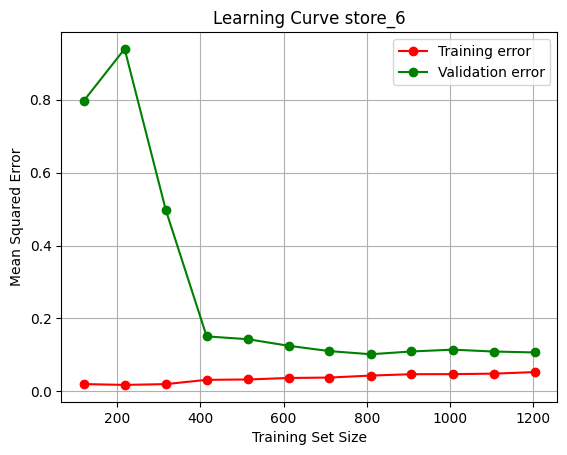

In [ ]:
plot_learning_curve(svr, X_tr, y_tr)

## Predicciones de Ventas de Cada Tienda

In [ ]:
tiendas = np.empty(55,dtype=object)
for i in range(1,55):
  #Creando Xtrain,Ytrain,Xtest,Ytest
  train_filtered = main_df_train[main_df_train['store_nbr']==i]
  test_filtered = main_df_test[main_df_test['store_nbr']==i]

  columns_serie = train_filtered.columns.values
  columns_serie = np.delete(columns_serie,[0,2]) #Deleted date and sales 

  Xtrain = train_filtered.loc[:,columns_serie].values
  Ytrain = train_filtered.loc[:,'sales'].values
  Xtest = test_filtered.loc[:,columns_serie].values
  Ytest = test_filtered.loc[:,'sales'].values

  X_tr = sc_x.fit_transform(Xtrain)
  X_ts = sc_x.fit_transform(Xtest)
  y_tr = sc_y.fit_transform(Ytrain.reshape(-1,1)) 

  # Crear y entrenar modelo PCA
  pca = PCA()
  pca.fit(X_tr)

  #Determinar el numero optimo de componentes 
  cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
  n_components = np.argmax(cumsum_variance >= 0.95) + 1

  #Entrenar el modelo con el numero de componentes
  pca = PCA(n_components=n_components)
  pca.fit(X_tr)

  X_tr_pca  = pca.transform(X_tr)[:, :n_components]
  X_ts_pca  = pca.transform(X_ts)[:, :n_components]

  #Crear nuevo modelo con los mejores hiperparametros
  svr=SVR(C=params_SVR['C'], gamma=params_SVR['gamma'], epsilon=params_SVR['epsilon'])
  svr.fit(X_tr_pca, y_tr)
  y_hat = svr.predict(X_ts_pca)
  y_pred = sc_y.inverse_transform(y_hat.reshape(-1,1))
  y_pred = np.abs(y_pred)
  rmsle_test =(mean_squared_log_error(Ytest, y_pred ,squared=False))
  print("RMSLE tienda %d : %.3f"% (i,rmsle_test))

  tienda = {
      'tienda_id':i,
      'y_pred': y_pred,
      'rmsle':rmsle_test,
      'X_train_svr':X_tr,
      'y_train_svr':y_tr
  }

  tiendas[i] = tienda

RMSLE tienda 1 : 0.303
RMSLE tienda 2 : 0.289
RMSLE tienda 3 : 0.306
RMSLE tienda 4 : 0.260
RMSLE tienda 5 : 0.197
RMSLE tienda 6 : 0.286
RMSLE tienda 7 : 0.337
RMSLE tienda 8 : 0.311
RMSLE tienda 9 : 0.268
RMSLE tienda 10 : 0.222
RMSLE tienda 11 : 0.230
RMSLE tienda 12 : 0.375
RMSLE tienda 13 : 0.185
RMSLE tienda 14 : 0.319
RMSLE tienda 15 : 0.237
RMSLE tienda 16 : 0.228
RMSLE tienda 17 : 0.367
RMSLE tienda 18 : 0.614
RMSLE tienda 19 : 0.237
RMSLE tienda 20 : 1.730
RMSLE tienda 21 : 1.525
RMSLE tienda 22 : 1.787
RMSLE tienda 23 : 0.242
RMSLE tienda 24 : 0.305
RMSLE tienda 25 : 0.411
RMSLE tienda 26 : 0.263
RMSLE tienda 27 : 0.380
RMSLE tienda 28 : 0.417
RMSLE tienda 29 : 1.291
RMSLE tienda 30 : 0.469
RMSLE tienda 31 : 0.367
RMSLE tienda 32 : 0.496
RMSLE tienda 33 : 0.260
RMSLE tienda 34 : 0.158
RMSLE tienda 35 : 0.357
RMSLE tienda 36 : 0.534
RMSLE tienda 37 : 0.203
RMSLE tienda 38 : 0.273
RMSLE tienda 39 : 0.419
RMSLE tienda 40 : 0.471
RMSLE tienda 41 : 0.507
RMSLE tienda 42 : 1.431
R

In [ ]:
# Grafica
fig, axes = plt.subplots(18, 3, figsize = (20,50))
for i in range(1,55):
  #Calcular posicion de la grafica
  row, col = divmod(i - 1, 3)
  ax = axes[row, col]
  #filtrar tienda
  test_filtered = main_df_test[main_df_test['store_nbr']==i]
  #Grafica
  ax.plot(test_filtered['date'], test_filtered['sales'], color="blue", lw=2, label="true", alpha=.5)
  ax.plot(test_filtered['date'], tiendas[i]['y_pred'], color="red", lw=2, label="predict", alpha=.6)
  ax.set_title("store "+ str(i))
  ax.legend(loc='best')
  ax.grid()
  
plt.legend()
plt.tight_layout(pad=3)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Curva de Aprendizaje para cada Tienda

Procesando tienda 54

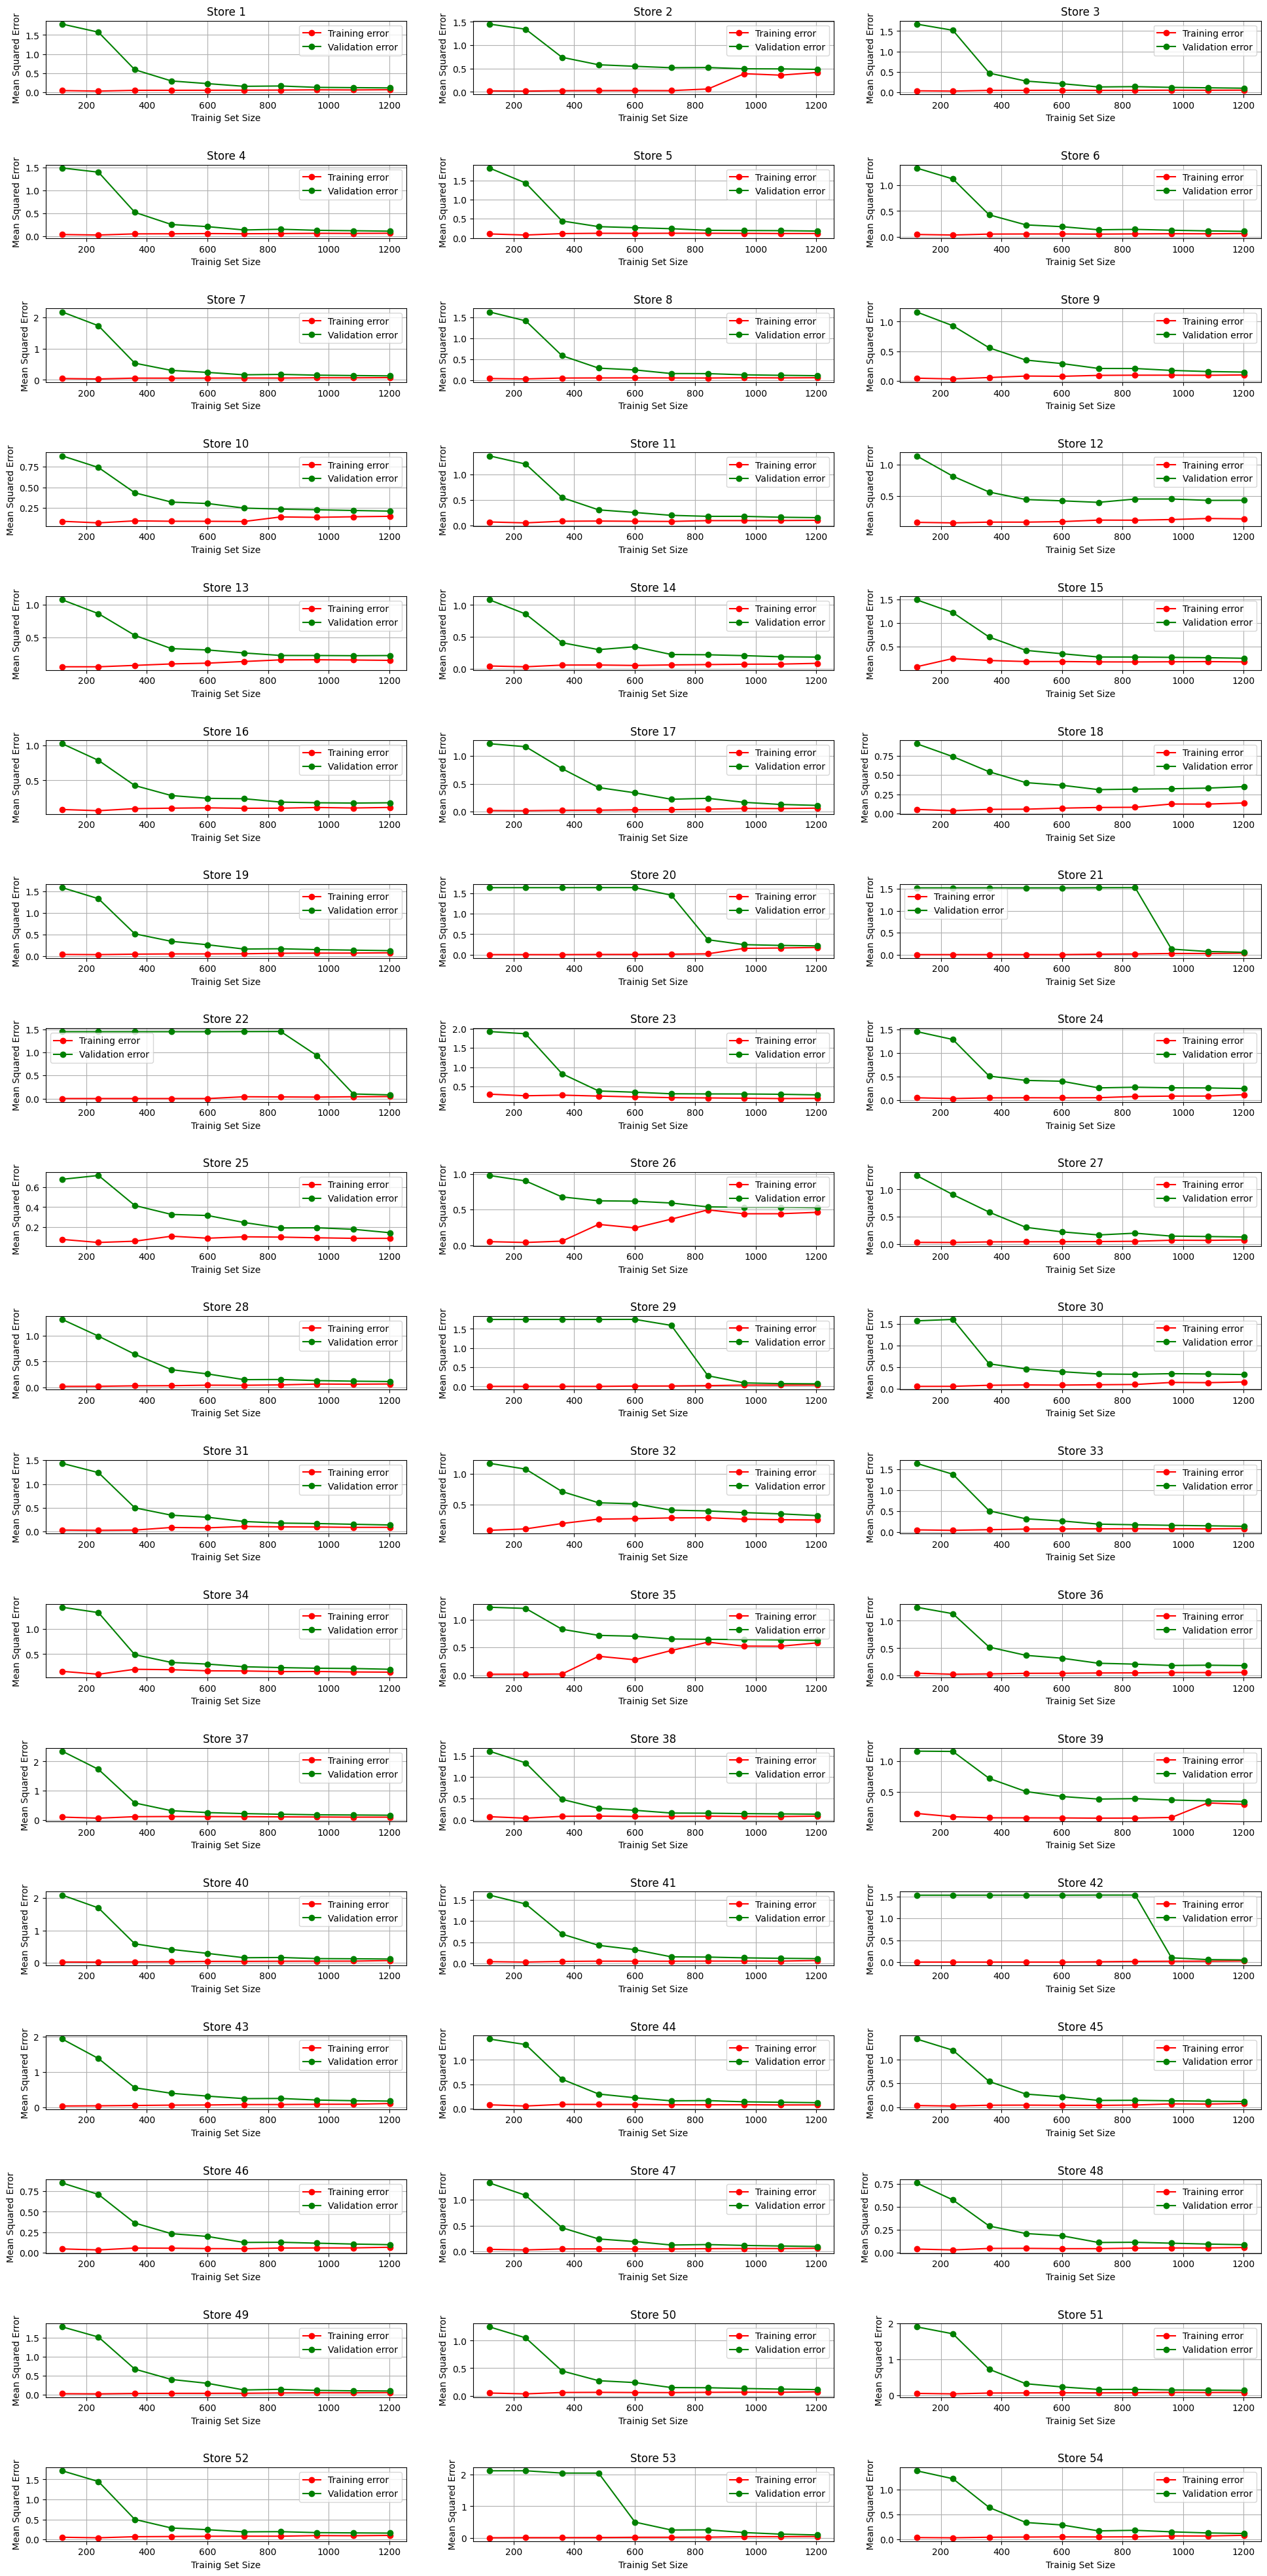

In [ ]:
#Learning curve
fig, axes = plt.subplots(18, 3, figsize = (20,40)) 
for i in range(1,55):
  mensaje = ("Procesando tienda "+ str(i))
  sys.stdout.write('\r'+mensaje)

  #Calcular posicion de la grafica
  row, col = divmod(i - 1, 3)
  ax = axes[row, col]
  #filtrar tienda
  train_filtered = main_df_train[main_df_train['store_nbr']==i]

  #plot_learning_curve()
  train_sizes, train_scores, test_scores = learning_curve(
      svr, tiendas[i]['X_train_svr'], tiendas[i]['y_train_svr'], cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))
  
  #promedio de los score para trian y test
  train_scores_mean = -np.mean(train_scores,axis=1)
  test_scores_mean = -np.mean(test_scores,axis=1)

  ax.plot(train_sizes, train_scores_mean, 'o-', label='Training error'  , color='r')
  ax.plot(train_sizes, test_scores_mean,  'o-', label='Validation error', color='g')

  ax.set_title('Store ' + str(i))
  ax.legend(loc='best')
  ax.grid(True)

  for ax in axes.flat:
    ax.set(xlabel='Trainig Set Size', ylabel='Mean Squared Error')

plt.tight_layout(pad=3)
plt.show()

# Conclusiones

Text(0, 0.5, 'RMSLE en test')

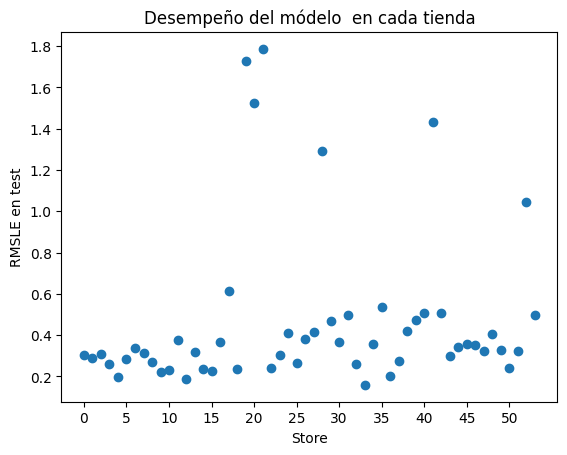

In [ ]:
store_id=np.arange(1,55)
scores_tienda=np.zeros(55)
for i in store_id:
  scores_tienda[i]=tiendas[i]['rmsle']
scores_tienda=scores_tienda[1:]
plt.scatter(np.arange(len(scores_tienda)),scores_tienda)
#plt.ylim([0, 0.5])
plt.xticks(np.arange(0,55,5))
plt.title('Desempeño del módelo  en cada tienda')
plt.xlabel("Store")
plt.ylabel("RMSLE en test")

In [ ]:
print('RSMLE max=', "%.4f" % max(scores_tienda))
print('RSMLE min=', "%.4f" % min(scores_tienda))
print('RSMLE promedio=', "%.4f" % np.mean(scores_tienda))

RSMLE max= 1.7867
RSMLE min= 0.1584
RSMLE promedio= 0.4608
